# Pythia in Python + Train Binary Classifier in PyTorch
This tutorial uses Pythia8 in python3 to generate a ttbar signal dataset and a QCD background dataset. A neural network is then trained to distinguish between signal and background.

### Import Pythia and Other Dependencies
The Makefile.inc in the pythia8312 directory includes some paths that must be added to your system paths in order to import pythia into python. If you are able to run this block, then your setup was successful!

In [1]:
# Add the necessary pythia build paths to the python paths
import sys
with open("Software/Software_Path.txt") as f:
    path = f.readline().strip()
cfg = open(path+"/pythia8312/Makefile.inc")  # Read necessary paths from this file
lib = "../lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break  # Find build paths
sys.path.insert(0, lib)   # Add build paths to system path

# Import Pythia8
import pythia8

# Import ML Libs
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline  

### Initialize Pythia with Signal and Background Processes

In [2]:
pythia_sig = pythia8.Pythia()                  # Define a pythia8.Pythia() object
pythia_sig.readString("Beams:eCM = 14000.")    # Beam energy is 14TeV
pythia_sig.readString("Beams:idA = 2212")      # Incoming particle 1 is proton
pythia_sig.readString("Beams:idB = 2212")      # Incoming particle 2 is proton
pythia_sig.readString("Top:all = on")          # Turn on all top processes
pythia_sig.init()                              # Initialize object with user defined settings

pythia_bkg = pythia8.Pythia()                  # Define a pythia8.Pythia() object
pythia_bkg.readString("Beams:eCM = 14000.")    # Beam enegery is 14TeV
pythia_bkg.readString("Beams:idA = 2212")      # Incoming particle 1 is proton
pythia_bkg.readString("Beams:idB = 2212")      # Incoming particle 2 is proton
pythia_bkg.readString("HardQCD:all = on")      # Turn on all HardQCD processes
pythia_bkg.init()                              # Initialize object with user defined settings


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.312      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 23 May 2024  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 11 Jul 2024 at 20:30:36    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

True

### Generate Dataset
Generate events and append stable particles to a list. Then histogram pT, eta, and phi for signal vs background.

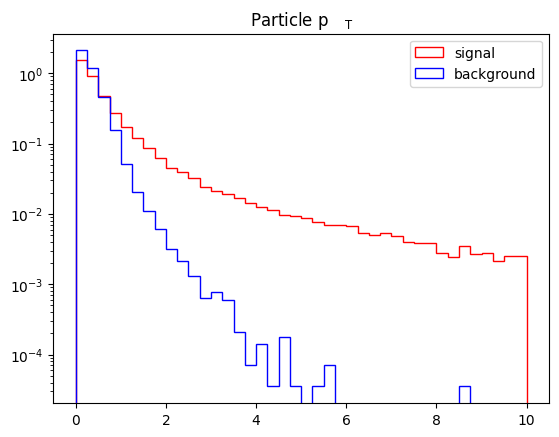

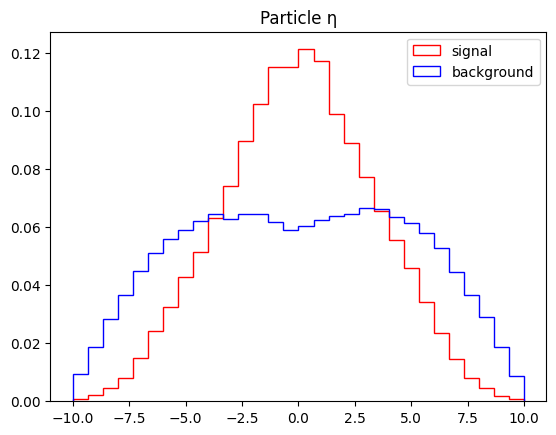

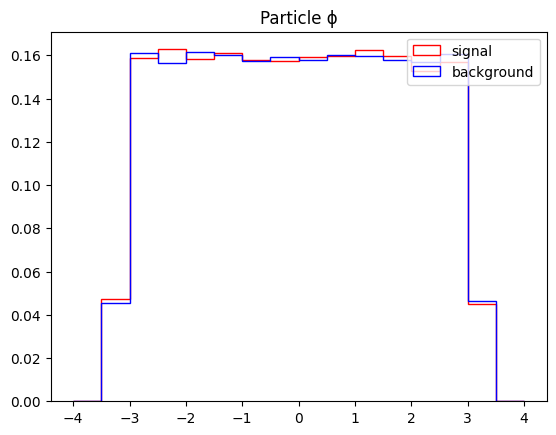

In [4]:
num_events = 1000

# Begin event loop. Generate event. Skip if error.
stbl_sig = []
for iEvent in range(num_events):           # Loop through events
    if not pythia_sig.next(): continue     # Standard pythia syntax to trigger next event generation
    for prt in pythia_sig.event:           # Loop through particles in each event
        if prt.isFinal():                  # Check if particle is final state particle and store pT, eta, phi
            stbl_sig.append([prt.pT(),prt.eta(),prt.phi()])
            
# Begin event loop. Generate event. Skip if error.
stbl_bkg = []
for iEvent in range(num_events):          # Loop through events
    if not pythia_bkg.next(): continue    # Standard pythia syntax to trigger enxt event generation
    for prt in pythia_bkg.event:          # Loop through particles in each event
        if prt.isFinal():                 # Chekc if particle is final stat particle and store pT, eta, phi
            stbl_bkg.append([prt.pT(),prt.eta(),prt.phi()])

num_particles = min([len(stbl_sig),len(stbl_bkg)])   # Determine which list is shorter
stbl_sig = np.array(stbl_sig[0:num_particles])       # Balance the dataset
stbl_bkg = np.array(stbl_bkg[0:num_particles])       # Balance the dataset

# Plot pT for signal and background
plt.title("Particle p   $\mathregular{_{\tT}}$")
plt.hist(stbl_sig[:,0],bins=40,range=(0,10),histtype='step',label='signal',color='r',density=True)
plt.hist(stbl_bkg[:,0],bins=40,range=(0,10),histtype='step',label='background',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

# Plot eta for signal and background
plt.title("Particle \u03B7")
plt.hist(stbl_sig[:,1],bins=30,range=(-10,10),histtype='step',label='signal',color='r',density=True)
plt.hist(stbl_bkg[:,1],bins=30,range=(-10,10),histtype='step',label='background',color='b',density=True)
plt.legend()
plt.show()

# Plot phi for signal and background
plt.title("Particle \u03D5")
plt.hist(stbl_sig[:,2],bins=16,range=(-4,4),histtype='step',label='signal',color='r',density=True)
plt.hist(stbl_bkg[:,2],bins=16,range=(-4,4),histtype='step',label='background',color='b',density=True)
plt.legend()
plt.show()

### Split Dataset Into Training and Testing Samples
It's best practice to use a training and testing dataset to verify that your model is not overfitting. Its also best practice to shuffle the dataset before training.

In [5]:
# Convert python lists to numpy arrays
X_sig = np.array(stbl_sig)
X_bkg = np.array(stbl_bkg)

# Generate labels sig=1 bkg=0
Y_sig = np.ones(num_particles)
Y_bkg = np.zeros(num_particles)

# Combine sig and bkg arrays
X = np.concatenate((X_sig, X_bkg),axis=0)
Y = np.concatenate((Y_sig, Y_bkg),axis=0)

# Generate random permuation of the indices
p = np.random.permutation(len(X))

# Shuffle X and Y according to randomized indices
X = X[p]
Y = Y[p]

# Split dataset into training and testing samples
# 70% train, 30% test
num_particles = len(Y)
X_train = X[0:int(0.7*num_particles)]
Y_train = Y[0:int(0.7*num_particles)].reshape((-1,1))
X_test = X[int(0.7*num_particles):]
Y_test = Y[int(0.7*num_particles):].reshape((-1,1))

# Convert numpy arrays to float32 torch tensors
X_train = torch.from_numpy(np.float32(X_train))
Y_train = torch.from_numpy(np.float32(Y_train))
X_test = torch.from_numpy(np.float32(X_test))
Y_test = torch.from_numpy(np.float32(Y_test))

# Print shapes of samples
print("X_train shape:\t", X_train.shape)
print("Y_train shape:\t", Y_train.shape)
print("X_test shape:\t", X_test.shape)
print("X_test shape:\t", Y_test.shape)

X_train shape:	 torch.Size([159019, 3])
Y_train shape:	 torch.Size([159019, 1])
X_test shape:	 torch.Size([68151, 3])
X_test shape:	 torch.Size([68151, 1])


### Define the Model and the Training Loop

In [6]:
# Define the Model
# Define a class that inherits from torch.nn.Module
class NeuralNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):    # Called when object is initialized
        super(NeuralNet, self).__init__()               # Call init function from parent class
        self.lin1 = nn.Linear(in_dim,hidden_dim)        # Define linear transformation 1
        self.lin2 = nn.Linear(hidden_dim,out_dim)       # Define linear transformation 2
    def forward(self, data):                         # Define a forward pass
        hidden_layer = F.relu(self.lin1(data))       # Transform using lin1 and use relu activation 
        output = F.sigmoid(self.lin2(hidden_layer))  # Transform using lin2 and use sigmoid activation
        return output                                # Return the models prediction

# Define the training loop
def train(model, data, epochs=20):
    X_train, y_train, X_test, y_test = data        # Unpack data

    history = {'train_loss':[],'test_loss':[]}     # Define history dictionary

    # Loop through epoches
    for e in range(epochs):
        # Train Model
        model.train()                        # Switch model to training mode
        optimizer.zero_grad()                # Reset the optimizers gradients
        outputs = model(X_train)             # Get the model prediction
        loss = loss_fn(outputs, y_train)     # Evaluate loss function
        loss.backward()                      # Backward propogation
        optimizer.step()                     # Gradient Descent

        # Validate Model
        model.eval()
        y_pred = model(X_test.to(device))    # Get model output on test data
        test_loss = loss_fn(y_pred,y_test)   # Evaluate loss on test preditions
        
        history['train_loss'].append(loss.detach().cpu().numpy())        # Append train loss to history (detach and convert to numpy array)
        history['test_loss'].append(test_loss.detach().cpu().numpy())    # Append test loss to history (detach and convert to numpy array)
        if e%100==0:
            print('Epoch:',e,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))

    return history

In [7]:
# Check if GPU is available, if not use cpu
gpu_available = torch.cuda.is_available()
mps_available = hasattr(torch, 'backends.mps.is_built') and torch.backends.mps.is_built()

print("GPU Available on linux system:", gpu_available)
print("Integrated GPU Available on Mac:", mps_available)

if gpu_available:
    device = torch.device("cuda:0")
elif mps_available:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

GPU Available on linux system: True
Integrated GPU Available on Mac: False
cuda:0


### Train Model and Plot Training History

NeuralNet(
  (lin1): Linear(in_features=3, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Trainable Parameters:  321 

Epoch: 0 	Train Loss: 0.702 	Test Loss: 0.7017
Epoch: 100 	Train Loss: 0.6703 	Test Loss: 0.6711
Epoch: 200 	Train Loss: 0.6539 	Test Loss: 0.655
Epoch: 300 	Train Loss: 0.6422 	Test Loss: 0.6435
Epoch: 400 	Train Loss: 0.6335 	Test Loss: 0.635
Epoch: 500 	Train Loss: 0.627 	Test Loss: 0.6285
Epoch: 600 	Train Loss: 0.622 	Test Loss: 0.6237
Epoch: 700 	Train Loss: 0.6183 	Test Loss: 0.62
Epoch: 800 	Train Loss: 0.6154 	Test Loss: 0.6172
Epoch: 900 	Train Loss: 0.6131 	Test Loss: 0.615


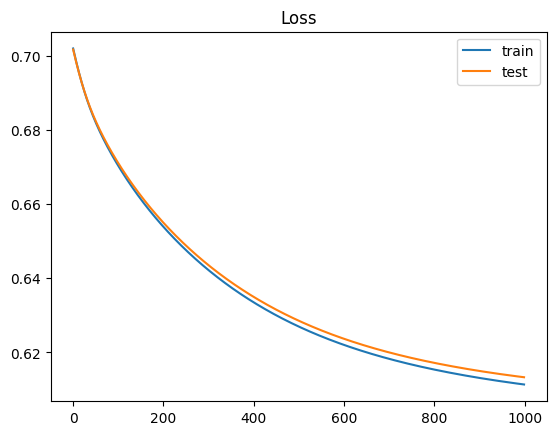

In [8]:
# Initialize model
model = NeuralNet(in_dim=3,hidden_dim=64,out_dim=1)    # Declare model using NeuralNet Class
model.to(device)                                       # Put model on device (cpu or gpu)
print(model)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
data = X_train.to(device), Y_train.to(device), X_test.to(device), Y_test.to(device)   # Send data to device (cpu or gpu)
history = train(model, data, epochs=1000)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.show()

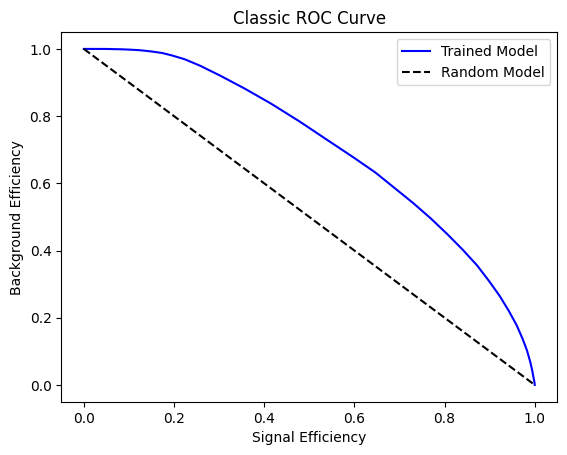

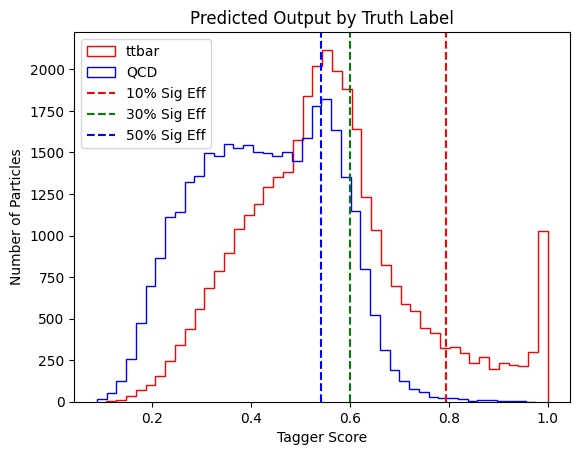

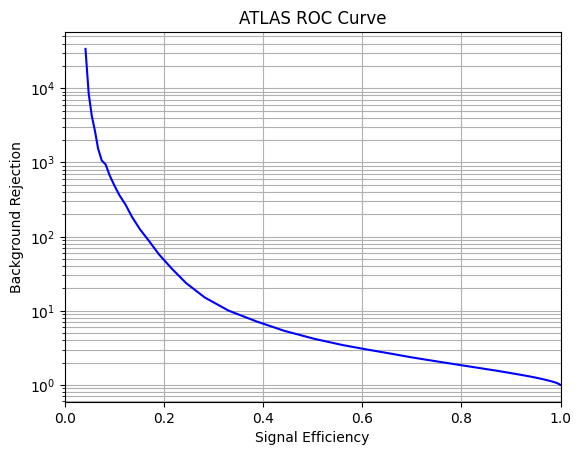

In [9]:
# Define traditional ROC curve
def roc(y_pred,y_true):    
    sig_eff = []
    bkg_eff = []
    
    # Iterate over thresholds and calculate sig and bkg efficiency
    for threshold in np.linspace(0,1,50):
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))   # Sum over sig predictions > threshold and divide by total number of true sig instances 
        bkg_eff.append(((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))  # Sum over bkg predictions < threshold and divide by total number of true bkg instances 
        
    return sig_eff, bkg_eff

# Define ATLAS Style ROC curve
def ATLAS_roc(y_pred,y_true):
    sig_eff = []
    bkg_eff = []
    thresholds = []
    
    for threshold in np.linspace(0,0.95,50):
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))
        thresholds.append(threshold)
        
    bkg_rej = [1/x for x in bkg_eff]  # ATLAS inverts bkg eff and uses bkg rejection instead
    return np.array(sig_eff), np.array(bkg_rej), np.array(thresholds)

# Get Models predictions
y_pred = model(X_test.to(device)).detach().cpu().numpy()

# Find indices of sig and bkg labels
sig = np.where(Y_test==1)[0]
bkg = np.where(Y_test==0)[0]

# Plot Tradiation ROC Curve
eff_sig, eff_bkg = roc(y_pred,Y_test.detach().cpu().numpy())
plt.title("Classic ROC Curve")
plt.plot(eff_sig,eff_bkg,color='b',label="Trained Model")
plt.plot([1,0],'--',color='k',label="Random Model")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend()
plt.show()

eff_sig, eff_bkg, cut = ATLAS_roc(y_pred,Y_test.detach().cpu().numpy())
# 10% WP
idx = max(np.where(eff_sig>0.1)[0])
cut1 = cut[idx]
# 30% WP
idx = max(np.where(eff_sig>0.3)[0])
cut2 = cut[idx]
# 50% WP
idx = max(np.where(eff_sig>0.50)[0])
cut3 = cut[idx]

# Plot Model Predictions split by sig and bkg
plt.title("Predicted Output by Truth Label")
plt.hist(y_pred[sig],histtype='step',label='ttbar',color='r',bins=45)
plt.hist(y_pred[bkg],histtype='step',label='QCD',color='b',bins=45)
plt.axvline(x = cut1, color="r", linestyle="--", label="10% Sig Eff")
plt.axvline(x = cut2, color="g", linestyle="--", label="30% Sig Eff")
plt.axvline(x = cut3, color="b", linestyle="--", label="50% Sig Eff")
plt.legend()
plt.xlabel("Tagger Score")
plt.ylabel("Number of Particles")
plt.show()

# Plot ATLAS Style ROC Curve
plt.title("ATLAS ROC Curve")
plt.plot(eff_sig,eff_bkg,color='b',label="Trained Model")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale('log')
plt.grid(True,which='both')
plt.xlim([0, 1])
plt.show()

Notice the steep increase in background rejection, however, we must cut over 90% of our signal samples to achieve such high background rejection.